In [1]:
%run ./VA_sentencing_reform_v1_utils.ipynb

52291


In [2]:
reload(incarceration_transitions)
reload(population_simulation)

<module 'spark.sentencing_policy_impact_v1.population_simulation' from '../../spark/sentencing_policy_impact_v1/population_simulation.py'>

In [4]:
mm_reduction_5y = partial(
    incarceration_transitions.IncarceratedTransitions.apply_mandatory_minimum_reduction,
    sentence_reduction_years=5,
)
abolish_mm = partial(
    incarceration_transitions.IncarceratedTransitions.apply_mandatory_minimum_reduction,
    sentence_reduction_years=None,
)

user_inputs = {"projection_years": 10}

policy_df = pd.DataFrame(
    [
        {
            "simulation_group_name": "DRUG/SCHEDULE I/II_0",
            "year": 2020,
            "compartment": "prison",
            "policies": [abolish_mm],
        },
        {
            "simulation_group_name": "DRUG/SCHEDULE I/II_0",
            "year": 2020,
            "compartment": "jail",
            "policies": [abolish_mm],
        },
        {
            "simulation_group_name": "DRUG/SCHEDULE I/II_1",
            "year": 2020,
            "compartment": "prison",
            "policies": [mm_reduction_5y],
        },
    ]
)

policy_df = pd.DataFrame(
    columns=["simulation_group_name", "year", "compartment", "policies"]
)
no_policy_df = pd.DataFrame(
    columns=["simulation_group_name", "year", "compartment", "policies"]
)

In [5]:
test_data = jail_prison_admissions[
    jail_prison_admissions["offense_group"] == "DRUG/SCHEDULE I/II"
]
test_sim = population_simulation.PopulationSimulation()
counterfactual_sim = population_simulation.PopulationSimulation()
test_results = test_sim.simulate_sentencing_policies(test_data, user_inputs, policy_df)
counterfactual_results = counterfactual_sim.simulate_sentencing_policies(
    test_data, user_inputs, no_policy_df
)

initialization time:  0.0385127067565918
simulation_time:  18.431827068328857
initialization time:  0.028604984283447266
simulation_time:  18.69565486907959


In [6]:
test_results.groupby(level=0).sum()["total_population"]

1998         2.000000
1999         4.000000
2000      5344.000000
2001     10684.000000
2002     15945.595568
2003     21017.143962
2004     25899.669025
2005     30646.224461
2006     35268.778353
2007     39772.987594
2008     44163.544163
2009     48444.540930
2010     52619.287486
2011     56688.475960
2012     60654.257923
2013     64519.809926
2014     68288.375282
2015     71962.448345
2016     75544.443899
2017     79036.704592
2018     82706.506034
2019     86590.060601
2020     90382.722711
2021     94072.263059
2022     97657.663675
2023    101148.880821
2024    104552.427450
2025    107870.841422
2026    111106.198676
2027    114260.586491
2028    117290.563440
2029    120288.233499
Name: total_population, dtype: float64

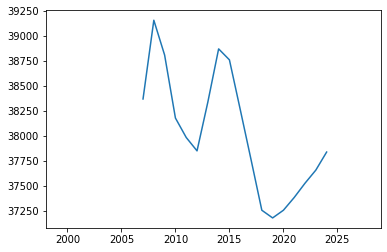

In [7]:
from spark.sentencing_policy_impact_v1.historical_data import (
    total_state_responsible_adult_population,
)

population_change = (
    test_results.groupby(level=0).sum()["total_population"]
    - counterfactual_results.groupby(level=0).sum()["total_population"]
)
policy_projection = total_state_responsible_adult_population + population_change
policy_projection.plot()

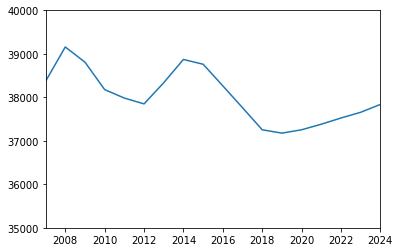

In [10]:
total_state_responsible_adult_population.plot(ylim=[35000, 40000])

/Users/justine/.local/share/virtualenvs/recidiviz-research--v7DE6HN/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


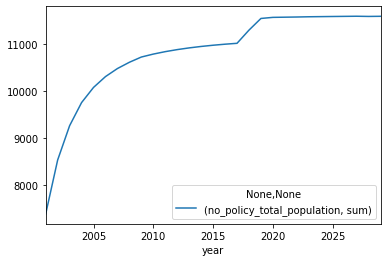

In [12]:
simulation_results = format_simulation_results(test_results, "no_policy")
# simulation_results = simulation_results.merge(format_simulation_results(no_policy_results, 'no_policies'),
#                                               on=['compartment', 'year'])
simulation_results = simulation_results[
    (simulation_results["compartment"] != "pretrial")
]
simulation_results_plot = simulation_results[(simulation_results["year"] > 2000)]
simulation_results_plot[simulation_results_plot["compartment"] != "release"].groupby(
    "year"
).sum().plot()

In [13]:
test_data["year"].value_counts(dropna=False)

[2000    816.000000
 2001    407.110465
 2002    136.395349
 2003     55.447674
 2004     26.686047
 2005     12.453488
 2006      6.523256
 2007      3.558140
 2008      2.372093
 2009      2.075581
 2010      1.482558
 2011      0.704215
 2012      0.334502
 2013      0.158889
 2014      0.075472
 2015      0.035849
 2016      0.017028
 2017      0.008088
 2018      0.003842
 2019      0.001825
 2020      0.000867
 2021      0.000412
 2022      0.000196
 2023      0.000093
 2024      0.000044
 2025      0.000021
 2026      0.000010
 2027      0.000005
 2028      0.000002
 2029      0.000001
 dtype: float64,
 2000    61.000000
 2001    38.039326
 2002    11.651685
 2003     2.741573
 2004     0.342697
 2005     0.342697
 2006     0.342697
 2007     0.000000
 dtype: float64,
 2000    245.000000
 2001    243.244986
 2002    238.330946
 2003    176.905444
 2004    139.699140
 2005    105.300860
 2006     70.902579
 2007     58.266476
 2008     41.418338
 2009     29.133238
 2010     16.4

In [26]:
test_data[test_data["effective_sentence_years"] <= 1]["year"].value_counts(dropna=False)

2019.0    3924
2018.0    3619
2017.0    3258
Name: year, dtype: int64

In [5]:
test_data = jail_prison_admissions[
    jail_prison_admissions["simulation_group_name"] == "NAR3038"
]
test_sim = population_simulation.PopulationSimulation()
test_results = test_sim.simulate_sentencing_policies(test_data, user_inputs, policy_df)
test_results

initialization time:  0.005460023880004883
simulation_time:  1.8137788772583008


total_population compartment  year simulation_group
2000        245.000000      prison  2000          NAR3038
2001        488.244986      prison  2001          NAR3038
2002        726.575931      prison  2002          NAR3038
2003        903.481375      prison  2003          NAR3038
2004       1043.180516      prison  2004          NAR3038
...                ...         ...   ...              ...
2025          0.000000    pretrial  2025          NAR3038
2026          0.000000    pretrial  2026          NAR3038
2027          0.000000    pretrial  2027          NAR3038
2028          0.000000    pretrial  2028          NAR3038
2029          0.000000    pretrial  2029          NAR3038

[120 rows x 4 columns]

Text(0.5, 1.0, 'Total Population for Group NAR3038')

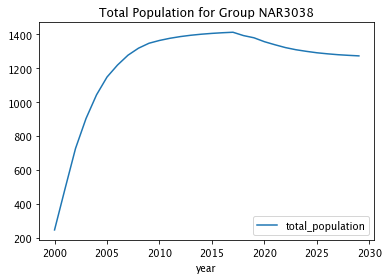

In [6]:
test_results[test_results["compartment"] == "prison"].plot(
    x="year", y="total_population"
)
plt.title(
    f"Total Population for Group {', '.join(test_results['simulation_group'].unique())}"
)

In [12]:
test_sim_cohorts = (
    test_sim.sub_simulations["NAR3038"]
    .simulation_compartments["prison"]
    .get_cohort_table()
)
test_sim_cohorts[range(2015, 2022)]

2015        2016        2017        2018        2019        2020  \
2000    4.811581    3.760657    2.939270    2.297288    1.795524    1.403354   
2001    6.156189    4.811581    3.760657    2.939270    2.297288    1.795524   
2002    7.876551    6.156189    4.811581    3.760657    2.939270    2.297288   
2003   10.077673    7.876551    6.156189    4.811581    3.760657    2.939270   
2004   12.893902   10.077673    7.876551    6.156189    4.811581    3.760657   
2005   16.497135   12.893902   10.077673    7.876551    6.156189    4.811581   
2006   29.133238   16.497135   12.893902   10.077673    7.876551    6.156189   
2007   41.418338   29.133238   16.497135   12.893902   10.077673    7.876551   
2008   58.266476   41.418338   29.133238   16.497135   12.893902   10.077673   
2009   70.902579   58.266476   41.418338   29.133238   16.497135   12.893902   
2010  105.300860   70.902579   58.266476   41.418338   29.133238   16.497135   
2011  139.699140  105.300860   70.902579   58.266476   41.418338   29.133238   
2012  176.905444  139.699140  105.300860   70.902579   58.266476   41.418338   
2013  238.330946  176.905444  139.699140  105.300860   70.902579   58.266476   
2014  243.244986  238.330946  176.905444  139.699140  105.300860   70.902579   
2015  245.000000  243.244986  238.330946  176.905444  139.699140  105.300860   
2016         NaN  245.000000  243.244986  238.330946  176.905444  139.699140   
2017         NaN         NaN  245.000000  243.244986  238.330946  176.905444   
2018         NaN         NaN         NaN  223.000000  221.402579  216.929799   
2019         NaN         NaN         NaN         NaN  230.000000  228.352436   
2020         NaN         NaN         NaN         NaN         NaN  219.880942   
2021         NaN         NaN         NaN         NaN         NaN         NaN   
2022         NaN         NaN         NaN         NaN         NaN         NaN   
2023         NaN         NaN         NaN         NaN         NaN         NaN   
2024         NaN         NaN         NaN         NaN         NaN         NaN   
2025         NaN         NaN         NaN         NaN         NaN         NaN   
2026         NaN         NaN         NaN         NaN         NaN         NaN   
2027         NaN         NaN         NaN         NaN         NaN         NaN   
2028         NaN         NaN         NaN         NaN         NaN         NaN   
2029         NaN         NaN         NaN         NaN         NaN         NaN   

            2021  
2000    1.096839  
2001    1.403354  
2002    1.795524  
2003    2.297288  
2004    2.939270  
2005    3.760657  
2006    4.811581  
2007    6.156189  
2008    7.876551  
2009   10.077673  
2010   12.893902  
2011   16.497135  
2012   29.133238  
2013   41.418338  
2014   58.266476  
2015   70.902579  
2016  105.300860  
2017  139.699140  
2018  161.020057  
2019  223.739255  
2020  218.305864  
2021  219.842898  
2022         NaN  
2023         NaN  
2024         NaN  
2025         NaN  
2026         NaN  
2027         NaN  
2028         NaN  
2029         NaN

Text(0.5, 1.0, 'Total Population per Cohort for NAR3038')

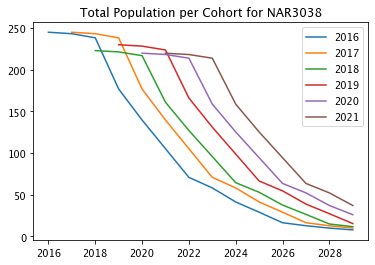

In [16]:
test_sim_cohorts.loc[range(2016, 2022)].transpose().plot()
plt.title(
    f"Total Population per Cohort for {', '.join(test_results['simulation_group'].unique())}"
)

In [14]:
test_sim.sub_simulations["NAR3038"].simulation_compartments["pretrial"].historical_data

2017.0  2018.0  2019.0
prison     205     186     192
jail         2       1       0

In [19]:
test_data["year"].value_counts(dropna=False)

2017.0    247
2019.0    230
2018.0    224
Name: year, dtype: int64

In [56]:
releases_2015 = 0
for i in [
    test_sim.sub_simulations[i].simulation_compartments["release"].cohorts
    for i in test_sim.sub_simulations
]:
    for j in i:
        try:
            j.get_all_year_end_projections()[2014]

        except:
            try:
                releases_2015 += j.get_all_year_end_projections()[2015]
            except:
                pass
releases_2015

5308.31112389623

In [9]:
3 / 4 * releases_2015

3339.394482298573

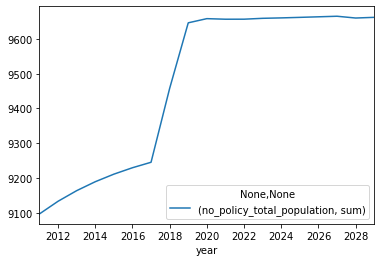

In [10]:
simulation_results = format_simulation_results(test_results, "no_policy")
# simulation_results = simulation_results.merge(format_simulation_results(no_policy_results, 'no_policies'),
#                                               on=['compartment', 'year'])
simulation_results = simulation_results[
    (simulation_results["compartment"] != "pretrial")
]
simulation_results_plot = simulation_results[(simulation_results["year"] > 2010)]
simulation_results_plot[simulation_results_plot["compartment"] != "release"].groupby(
    "year"
).sum().plot()

In [ ]:
# FULL SYSTEM SIM BELOW: TAKES 10 MINS TO LOAD SO TRY NOT TO RE-RUN

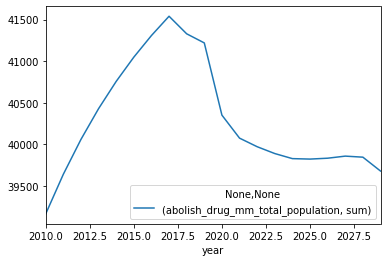

In [18]:
simulation_results = format_simulation_results(test_results, "abolish_drug_mm")
# simulation_results = simulation_results.merge(format_simulation_results(no_policy_results, 'no_policies'),
#                                               on=['compartment', 'year'])
simulation_results = simulation_results[
    (simulation_results["compartment"] != "pretrial")
]
simulation_results = simulation_results[(simulation_results["year"] >= 2010)]
simulation_results[simulation_results["compartment"] != "release"].groupby(
    "year"
).sum().plot()

In [20]:
# all
(
    test_results.loc[2019].groupby("compartment").sum()
    - test_results.loc[2025].groupby("compartment").sum()
)

total_population  year
compartment                        
jail               353.769623 -1482
pretrial             0.000000 -1482
prison            1042.811534 -1482
release         -54269.100162 -1482

In [21]:
releases_2015 = 0
for i in [
    test_sim.sub_simulations[i].simulation_compartments["release"].cohorts
    for i in test_sim.sub_simulations
]:
    for j in i:
        try:
            j.get_all_year_end_projections()[2015]

        except:
            try:
                releases_2015 += j.get_all_year_end_projections()[2016]
            except:
                pass
releases_2015

17526.263385529048

In [ ]:
count = 0
l = 0
for id, offense in historical_admissions.sort_values(
    "effective_sentence_years"
).iterrows():
    if count < 0.95 * len(historical_admissions):
        l = offense["effective_sentence_years"]
        count += 1
    else:
        break
count = 0
for id, offense in historical_admissions.iterrows():
    print(offense["effective_sentence_years"])
    if 10 == offense["effective_sentence_years"]:
        count += 1
    else:
        break
count

In [ ]:
prison_type_1_assault = historical_admissions[
    (historical_admissions["sentence_type"] == "prison")
    & (historical_admissions["offense_group"] == "ASSAULT")
    & (historical_admissions["offense_category_code"] == 1)
]
print(len(prison_type_1_assault))

prison_type_0_assault = historical_admissions[
    (historical_admissions["sentence_type"] == "prison")
    & (historical_admissions["offense_group"] == "ASSAULT")
    & (historical_admissions["offense_category_code"] == 0.0)
]
print(len(prison_type_0_assault))

prison_type_1_assault_transitions = incarceration_transitions.IncarceratedTransitions(
    ["prison", "release", "jail"]
)
prison_type_1_assault_transitions.generate_transition_tables(prison_type_1_assault)
prison_type_1_assault_transitions.normalize_transitions()

prison_type_0_assault_transitions = incarceration_transitions.IncarceratedTransitions(
    ["prison", "release", "jail"]
)
prison_type_0_assault_transitions.generate_transition_tables(prison_type_0_assault)
prison_type_0_assault_transitions.normalize_transitions()

In [ ]:
prison_type_1_assault_transitions.transition_df.plot()
plt.title("transition probabilities vs time in prison for type-1 assault")
prison_type_0_assault_transitions.transition_df.plot()
plt.title("transition probabilities vs time in prison for type-0 assault")

In [ ]:
default_transition_class = incarceration_transitions.IncarceratedTransitions(
    ["release"]
)
default_transition_class.generate_transition_tables(prison_type_1_assault)
default_transition_class.normalize_transitions()

In [ ]:
mm_reduction_5y = partial(
    incarceration_transitions.IncarceratedTransitions.apply_mandatory_minimum_reduction,
    sentence_reduction_years=5,
)

mm_reduction_5y_transition_class = incarceration_transitions.IncarceratedTransitions(
    ["release"]
)
mm_reduction_5y_transition_class.generate_transition_tables(prison_type_1_assault)
mm_reduction_5y(mm_reduction_5y_transition_class)
mm_reduction_5y_transition_class.normalize_transitions()

In [ ]:
mm_reduction_5y_transition_class.transition_df.plot()
default_transition_class.transition_df.plot()

In [ ]:
abolish_mm_transition_class = incarceration_transitions.IncarceratedTransitions(
    ["release"]
)
abolish_mm_transition_class.generate_transition_tables(prison_type_1_assault)
abolish_mm_transition_class.apply_mandatory_minimum_reduction()
abolish_mm_transition_class.normalize_transitions()
abolish_mm_transition_class.transition_df.plot()

In [ ]:
prison_type_1_assault["effective_sentence_years"].describe()